#  challenge

The challenge consists of three parts - the first two require code as output, for the third part only a conceptual, text-based answer is needed.

# 1) Occupancy prediction model

### Challenge Description

You are provided with time series data from motion sensors (in this case [passive infrared sensors](https://en.wikipedia.org/wiki/Passive_infrared_sensor)). These sensors can be installed in buildings to help determine occupancy of rooms or movement in corridors. The data from these devices can be used to turn lights on and off or to derive optimized heating or ventilation schedules. Judging from the readings, you might know that nobody is usually in the office at a certain time of day so you can turn of the ventilation at this time. 

In our case, sensors were installed in 7 different meeting rooms of an office building and recorded occupancy values in these rooms for two months (July and August 2016). Your objective is to write a *model* which can *predict occupancy for the next 24h after a given timestamp*. The input for the predictor are all sensor readings up to the given timestamp. The output should be a value of 1 if you predict that the room will be occupied and 0 if you predict that it will not be occupied for each of the following 24 hours. You evaluate your predictor based on a score that compares the predicted states with the actual states in the test set.

Are there any points you could think of that could help improve your result (e.g. what if you had more data)?

### Submission details

You should create a program that takes 3 arguments like this:

    ./sample_solution.py <timestamp> <input file csv> <output file csv>

* `timestamp` Is the input time. Your predictions should begin in
the hour following this timestamp.
* `input file` The history of all sensor readings up to the input time. See
format in `data/device_activations.csv`. The sensors in the different rooms are called 'device_[1-7]'.

* `output file` This is where you write your results to. See format in
`data/sample_solution.csv`

### Dummy solution

To help make input / output easy to understand we have included a dummy solution as well as some sample data. If you run it as follows

    ./sample_solution.py '2016-08-31 23:59:59' data/device_activations.csv myresult.csv

Then you should get the file `data/sample_solutions.csv`.


# 2) Dockerized REST API

Now that you have a model that serves predictions, build a simple Python application that predicts the occupancy of one or several rooms for the next 24 hours!

This task consists in *writing a simple REST API* with a single endpoint (GET or POST) that returns those predictions for the next 24 hours as JSON. Ideally, use Docker to containerize your API.

Example usage of your Docker application:

    docker build -t <your-rest-api-docker-image> .
    docker run -t <your-rest-api-docker-image> -d
    curl http://<DOCKER-IP>:5000/predict


# 3) Scalability and Real-time processing

Now imagine that we don't have just a few sensors but thousands of them constantly sending data to the cloud. We want to set up a data infrastructure that can handle this data. The architecture should contain a batch processing, as well as a real-time processing layer.

For instance, batch processing could be used to train (and regularly update) a predictive model for each of these devices. On the other hand, real-time processing could be used to apply simple data processing (e.g. aggregations over time, data cleaning etc.) or to use the trained models to the incoming data stream to do predictions.

How could such an architecture look like? Please provide a brief sketch.

Please, mention *anything* that might seem important to you, for instance:

- What kind of technologies would you use?
- Would you have a preferred Cloud infrastructure?
- Where/how would you store data? Multiple databases for different kinds of
  data? Which ones?
- On top of what is mentioned above, what would you use the batch/real-time
  pipeline for?
- What kind of questions would you need to have answered in order to solve this
  task more concretely or in order to make better decisions on architecture and
  technologies?

# Evaluation
Your challenge results will be evaluated based on the following criteria
- prediction accuracy (for the first part)
- code cleanliness
- level of creativity / ingenuity of your solution

# Questions?



In [1]:
# %cd ..
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext autotime

import os
import pandas as pd
import numpy as np
import catboost as ctb
from sklearn import metrics
import seaborn as sns
sns.set_style('dark')

In [2]:
df = pd.read_csv('data/device_activations.csv', parse_dates=['time'])

time: 27.8 ms


In [3]:
sample_sol = pd.read_csv('data/sample_solution.csv', parse_dates=['time'])

time: 6.53 ms


In [43]:
df = df[df.device == 'device_2']

time: 16.8 ms


In [45]:
df2  = df.set_index('time').groupby(pd.Grouper(freq='H'))['device_activated'].sum().reset_index()

time: 11 ms


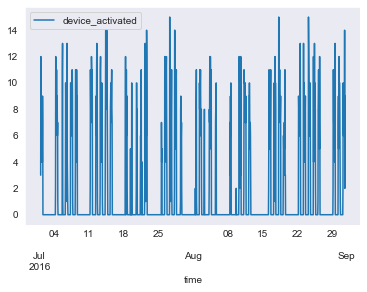

time: 1.15 s


In [6]:
df2.plot('time', 'device_activated');

In [7]:
df2.device_activated = df2.device_activated.map(lambda x: 1 if x > 0 else 0)

time: 3.82 ms


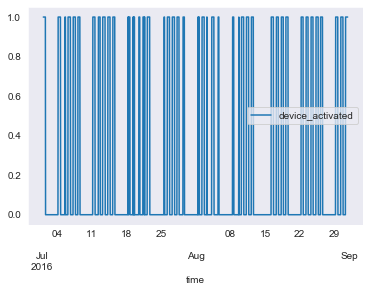

time: 1.6 s


In [8]:
df2.plot('time', 'device_activated');

In [11]:
split_point = -len(df2)//10*2
train = df2[:split_point]
test = df2[split_point:]

test_preds = test.set_index('time').copy()

train = train.set_index('time')
train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)

### Baseline: pred 1 week ago

In [84]:
preds = train.copy()

time: 1.04 ms


In [94]:
preds.index.max() < test_preds.index.max()

True

time: 7.47 ms


In [95]:
while preds.index.max() < test_preds.index.max():
    preds = preds.shift(7, freq='D')
    idx = test_preds.index.intersection(preds.index)
    test_preds.loc[idx, 'device_activated'] = preds.loc[idx, 'device_activated']

time: 12.4 ms


In [96]:
print(metrics.classification_report(test.device_activated, test_preds.reset_index().device_activated))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       205
           1       0.91      0.64      0.75        91

    accuracy                           0.87       296
   macro avg       0.88      0.80      0.83       296
weighted avg       0.87      0.87      0.86       296

time: 6.23 ms


In [97]:
metrics.f1_score(test.device_activated, test_preds.reset_index().device_activated)

0.7483870967741935

time: 9.12 ms


#### So it's quite good already, let's try ARIMA

In [54]:
freq=train.index.inferred_freq
freq

'H'

time: 2.07 ms


In [104]:
import itertools
p = d = q = range(0, 2) # Define the p, d and q parameters to take any value between 0 and 2
s = [1, 2, 4, 5, 6, 7, 8, 12]
pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
pdq_x_QDQs = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(p, d, q, s))] # Generate all different combinations of seasonal p, q and q triplets
print('Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], pdq_x_QDQs[1]))
print('SARIMAX: {} x {}'.format(pdq[2], pdq_x_QDQs[2]))

Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 2)
SARIMAX: (0, 1, 0) x (0, 0, 0, 4)
time: 2.74 ms


In [105]:
res = []
import statsmodels.api as sm
for param in pdq:
    for seasonal_param in pdq_x_QDQs:
#         try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            res.append([param, seasonal_param, results.aic])
#             print('ARIMA{}x{} - AIC:{}'.format(param, seasonal_param, results.aic))
#         except:
#             continue

ARIMA(0, 0, 0)x(0, 0, 0, 1) - AIC:1717.949198632363
ARIMA(0, 0, 0)x(0, 0, 0, 2) - AIC:1717.949198632363
ARIMA(0, 0, 0)x(0, 0, 0, 4) - AIC:1717.949198632363
ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC:1717.949198632363
ARIMA(0, 0, 0)x(0, 0, 0, 6) - AIC:1717.949198632363
ARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:1717.949198632363
ARIMA(0, 0, 0)x(0, 0, 0, 8) - AIC:1717.949198632363
ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:1717.949198632363
ARIMA(0, 0, 0)x(0, 0, 1, 1) - AIC:839.0113420649436
ARIMA(0, 0, 0)x(0, 0, 1, 2) - AIC:1110.9817694855337
ARIMA(0, 0, 0)x(0, 0, 1, 4) - AIC:1360.6483178651292
ARIMA(0, 0, 0)x(0, 0, 1, 5) - AIC:1367.1645652075335
ARIMA(0, 0, 0)x(0, 0, 1, 6) - AIC:1434.241984878268
ARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:1558.8298481858196
ARIMA(0, 0, 0)x(0, 0, 1, 8) - AIC:1633.7004269674876
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1674.335239333116
ARIMA(0, 0, 0)x(0, 1, 0, 1) - AIC:147.78532199782134
ARIMA(0, 0, 0)x(0, 1, 0, 2) - AIC:885.8928421591131
ARIMA(0, 0, 0)x(0, 1, 0, 4) - AIC:1545.6720673282027
ARI

/Users/eamag/anaconda3/envs/pairf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 7) - AIC:784.1089857664542
ARIMA(0, 0, 1)x(1, 0, 0, 8) - AIC:781.624954493491
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:812.3419748785383
ARIMA(0, 0, 1)x(1, 0, 1, 1) - AIC:72.7090144684737
ARIMA(0, 0, 1)x(1, 0, 1, 2) - AIC:74.37753926762694
ARIMA(0, 0, 1)x(1, 0, 1, 4) - AIC:519.1267854595079
ARIMA(0, 0, 1)x(1, 0, 1, 5) - AIC:710.8968064825323
ARIMA(0, 0, 1)x(1, 0, 1, 6) - AIC:666.8173291016096
ARIMA(0, 0, 1)x(1, 0, 1, 7) - AIC:634.2021571712596
ARIMA(0, 0, 1)x(1, 0, 1, 8) - AIC:599.9528853968852
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:636.6705959148774
ARIMA(0, 0, 1)x(1, 1, 0, 1) - AIC:50.728364350427285
ARIMA(0, 0, 1)x(1, 1, 0, 2) - AIC:141.69936247127723
ARIMA(0, 0, 1)x(1, 1, 0, 4) - AIC:803.9769310573467
ARIMA(0, 0, 1)x(1, 1, 0, 5) - AIC:1087.5313524474197
ARIMA(0, 0, 1)x(1, 1, 0, 6) - AIC:1088.5926469334433
ARIMA(0, 0, 1)x(1, 1, 0, 7) - AIC:1152.4127287303068
ARIMA(0, 0, 1)x(1, 1, 0, 8) - AIC:1086.5069148395403
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:718.0384825132336
ARIMA

/Users/eamag/anaconda3/envs/pairf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 5) - AIC:588.32161734996
ARIMA(0, 0, 1)x(1, 1, 1, 6) - AIC:579.9079977115847
ARIMA(0, 0, 1)x(1, 1, 1, 7) - AIC:621.8840159423645
ARIMA(0, 0, 1)x(1, 1, 1, 8) - AIC:585.7570976761496
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:537.9620503261211
ARIMA(0, 1, 0)x(0, 0, 0, 1) - AIC:147.78532199782134
ARIMA(0, 1, 0)x(0, 0, 0, 2) - AIC:147.78532199782134
ARIMA(0, 1, 0)x(0, 0, 0, 4) - AIC:147.78532199782134
ARIMA(0, 1, 0)x(0, 0, 0, 5) - AIC:147.78532199782134
ARIMA(0, 1, 0)x(0, 0, 0, 6) - AIC:147.78532199782134
ARIMA(0, 1, 0)x(0, 0, 0, 7) - AIC:147.78532199782134
ARIMA(0, 1, 0)x(0, 0, 0, 8) - AIC:147.78532199782134
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:147.78532199782134
ARIMA(0, 1, 0)x(0, 0, 1, 1) - AIC:144.73465487416527
ARIMA(0, 1, 0)x(0, 0, 1, 2) - AIC:141.9864920450402
ARIMA(0, 1, 0)x(0, 0, 1, 4) - AIC:153.28307105749656
ARIMA(0, 1, 0)x(0, 0, 1, 5) - AIC:150.32682917711074
ARIMA(0, 1, 0)x(0, 0, 1, 6) - AIC:154.73989745743108
ARIMA(0, 1, 0)x(0, 0, 1, 7) - AIC:155.11128444472587

/Users/eamag/anaconda3/envs/pairf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 0, 4) - AIC:615.1288448572878
ARIMA(0, 1, 0)x(1, 1, 0, 5) - AIC:712.6161272279767
ARIMA(0, 1, 0)x(1, 1, 0, 6) - AIC:717.5180481214694
ARIMA(0, 1, 0)x(1, 1, 0, 7) - AIC:627.8264530626346
ARIMA(0, 1, 0)x(1, 1, 0, 8) - AIC:611.4012786761243
ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:436.97184473665965
ARIMA(0, 1, 0)x(1, 1, 1, 1) - AIC:155.07527688596804
ARIMA(0, 1, 0)x(1, 1, 1, 2) - AIC:151.29288978747738
ARIMA(0, 1, 0)x(1, 1, 1, 4) - AIC:163.19207652164573
ARIMA(0, 1, 0)x(1, 1, 1, 5) - AIC:170.17114117576256
ARIMA(0, 1, 0)x(1, 1, 1, 6) - AIC:167.07396118397207
ARIMA(0, 1, 0)x(1, 1, 1, 7) - AIC:188.70469140907298
ARIMA(0, 1, 0)x(1, 1, 1, 8) - AIC:115.06803993728495
ARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:130.24098408026265
ARIMA(0, 1, 1)x(0, 0, 0, 1) - AIC:144.73465487416527
ARIMA(0, 1, 1)x(0, 0, 0, 2) - AIC:144.73465487416527
ARIMA(0, 1, 1)x(0, 0, 0, 4) - AIC:144.73465487416527
ARIMA(0, 1, 1)x(0, 0, 0, 5) - AIC:144.73465487416527
ARIMA(0, 1, 1)x(0, 0, 0, 6) - AIC:144.73465487416

/Users/eamag/anaconda3/envs/pairf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 4) - AIC:56.229358654496025
ARIMA(1, 0, 1)x(0, 1, 1, 5) - AIC:64.1412682848546
ARIMA(1, 0, 1)x(0, 1, 1, 6) - AIC:60.91192476958663
ARIMA(1, 0, 1)x(0, 1, 1, 7) - AIC:71.39105993977512
ARIMA(1, 0, 1)x(0, 1, 1, 8) - AIC:6.524077580839098
ARIMA(1, 0, 1)x(0, 1, 1, 12) - AIC:74.77221520392256
ARIMA(1, 0, 1)x(1, 0, 0, 1) - AIC:71.77792264754709
ARIMA(1, 0, 1)x(1, 0, 0, 2) - AIC:72.62393366626765
ARIMA(1, 0, 1)x(1, 0, 0, 4) - AIC:73.22966413091406
ARIMA(1, 0, 1)x(1, 0, 0, 5) - AIC:75.60521550344356
ARIMA(1, 0, 1)x(1, 0, 0, 6) - AIC:74.67829556289402
ARIMA(1, 0, 1)x(1, 0, 0, 7) - AIC:77.19358299246643
ARIMA(1, 0, 1)x(1, 0, 0, 8) - AIC:76.988452738871
ARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:41.79643598387246
ARIMA(1, 0, 1)x(1, 0, 1, 1) - AIC:80.67627710385803
ARIMA(1, 0, 1)x(1, 0, 1, 2) - AIC:75.1504587581981
ARIMA(1, 0, 1)x(1, 0, 1, 4) - AIC:75.59508297394254
ARIMA(1, 0, 1)x(1, 0, 1, 5) - AIC:76.13398866651293
ARIMA(1, 0, 1)x(1, 0, 1, 6) - AIC:69.49467790229963


/Users/eamag/anaconda3/envs/pairf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 7) - AIC:78.83862212981509
ARIMA(1, 0, 1)x(1, 0, 1, 8) - AIC:69.4373161179257
ARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:-90.38559634536927
ARIMA(1, 0, 1)x(1, 1, 0, 1) - AIC:52.310081424412076
ARIMA(1, 0, 1)x(1, 1, 0, 2) - AIC:140.0452723776491
ARIMA(1, 0, 1)x(1, 1, 0, 4) - AIC:493.1863456253899
ARIMA(1, 0, 1)x(1, 1, 0, 5) - AIC:599.0929544485869
ARIMA(1, 0, 1)x(1, 1, 0, 6) - AIC:602.4306134743003
ARIMA(1, 0, 1)x(1, 1, 0, 7) - AIC:533.2946104522757
ARIMA(1, 0, 1)x(1, 1, 0, 8) - AIC:512.3756127429701
ARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:307.64414309089324
ARIMA(1, 0, 1)x(1, 1, 1, 1) - AIC:58.38041044050247
ARIMA(1, 0, 1)x(1, 1, 1, 2) - AIC:142.02056569292722
ARIMA(1, 0, 1)x(1, 1, 1, 4) - AIC:58.39239796369509
ARIMA(1, 0, 1)x(1, 1, 1, 5) - AIC:67.16474204199412
ARIMA(1, 0, 1)x(1, 1, 1, 6) - AIC:62.93095517536255
ARIMA(1, 0, 1)x(1, 1, 1, 7) - AIC:83.58543066224021
ARIMA(1, 0, 1)x(1, 1, 1, 8) - AIC:14.156117259419489
ARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:21.850643036271713
ARIM

/Users/eamag/anaconda3/envs/pairf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 0, 4) - AIC:956.4064526258696
ARIMA(1, 1, 0)x(0, 1, 0, 5) - AIC:1012.6181786148686
ARIMA(1, 1, 0)x(0, 1, 0, 6) - AIC:943.1629523568976
ARIMA(1, 1, 0)x(0, 1, 0, 7) - AIC:982.482676217219
ARIMA(1, 1, 0)x(0, 1, 0, 8) - AIC:942.5573358829583
ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:1119.6465594268282
ARIMA(1, 1, 0)x(0, 1, 1, 1) - AIC:155.07527718074505
ARIMA(1, 1, 0)x(0, 1, 1, 2) - AIC:157.2985513091348
ARIMA(1, 1, 0)x(0, 1, 1, 4) - AIC:157.61379933346674
ARIMA(1, 1, 0)x(0, 1, 1, 5) - AIC:166.78568631741314
ARIMA(1, 1, 0)x(0, 1, 1, 6) - AIC:162.70815999430465
ARIMA(1, 1, 0)x(0, 1, 1, 7) - AIC:173.84406270115582
ARIMA(1, 1, 0)x(0, 1, 1, 8) - AIC:100.14768911212212
ARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:172.93009633764257
ARIMA(1, 1, 0)x(1, 0, 0, 1) - AIC:147.58076569943862
ARIMA(1, 1, 0)x(1, 0, 0, 2) - AIC:138.27535048235285
ARIMA(1, 1, 0)x(1, 0, 0, 4) - AIC:150.44582682331026
ARIMA(1, 1, 0)x(1, 0, 0, 5) - AIC:148.2516088631603
ARIMA(1, 1, 0)x(1, 0, 0, 6) - AIC:152.1292266575774

/Users/eamag/anaconda3/envs/pairf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 5) - AIC:55.35705990560615
ARIMA(1, 1, 1)x(1, 0, 0, 6) - AIC:56.09483292466536
ARIMA(1, 1, 1)x(1, 0, 0, 7) - AIC:56.77345821119404


/Users/eamag/anaconda3/envs/pairf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 8) - AIC:57.426097267419024
ARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:12.87388073757798
ARIMA(1, 1, 1)x(1, 0, 1, 1) - AIC:58.38041044050247


/Users/eamag/anaconda3/envs/pairf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 2) - AIC:54.988288776408496
ARIMA(1, 1, 1)x(1, 0, 1, 4) - AIC:55.47097939634605
ARIMA(1, 1, 1)x(1, 0, 1, 5) - AIC:55.38446181000647


/Users/eamag/anaconda3/envs/pairf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 6) - AIC:59.218260578773396
ARIMA(1, 1, 1)x(1, 0, 1, 7) - AIC:57.578913419417766
ARIMA(1, 1, 1)x(1, 0, 1, 8) - AIC:24.897339249399554
ARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:-118.5721531013553
ARIMA(1, 1, 1)x(1, 1, 0, 1) - AIC:156.8555993592334
ARIMA(1, 1, 1)x(1, 1, 0, 2) - AIC:435.29606835463824
ARIMA(1, 1, 1)x(1, 1, 0, 4) - AIC:505.55510973383196
ARIMA(1, 1, 1)x(1, 1, 0, 5) - AIC:707.0801720771994
ARIMA(1, 1, 1)x(1, 1, 0, 6) - AIC:657.4675979779416


/Users/eamag/anaconda3/envs/pairf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 7) - AIC:630.8485450678381
ARIMA(1, 1, 1)x(1, 1, 0, 8) - AIC:576.5899335792376
ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:426.64046359077145
ARIMA(1, 1, 1)x(1, 1, 1, 1) - AIC:130.91612430116902
ARIMA(1, 1, 1)x(1, 1, 1, 2) - AIC:150.7348924445063
ARIMA(1, 1, 1)x(1, 1, 1, 4) - AIC:75.28182382925776
ARIMA(1, 1, 1)x(1, 1, 1, 5) - AIC:165.04355093077805
ARIMA(1, 1, 1)x(1, 1, 1, 6) - AIC:165.0850894292521
ARIMA(1, 1, 1)x(1, 1, 1, 7) - AIC:99.69688697616327
ARIMA(1, 1, 1)x(1, 1, 1, 8) - AIC:116.25667609636483
ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:36.238588536835756
time: 3min 22s


In [110]:
pd.DataFrame(res, columns=['params', 'sparams', 'aic']).sort_values('aic').head(10)

,params,sparams,aic
495,"(1, 1, 1)","(1, 0, 1, 12)",-118.572153
367,"(1, 0, 1)","(1, 0, 1, 12)",-90.385596
303,"(1, 0, 0)","(1, 0, 1, 12)",-79.040046
239,"(0, 1, 1)","(1, 0, 1, 12)",-33.601008
431,"(1, 1, 0)","(1, 0, 1, 12)",-19.676469
286,"(1, 0, 0)","(0, 1, 1, 8)",3.807634
350,"(1, 0, 1)","(0, 1, 1, 8)",6.524078
175,"(0, 1, 0)","(1, 0, 1, 12)",9.128917
318,"(1, 0, 0)","(1, 1, 1, 8)",12.147133
487,"(1, 1, 1)","(1, 0, 0, 12)",12.873881


time: 29.5 ms


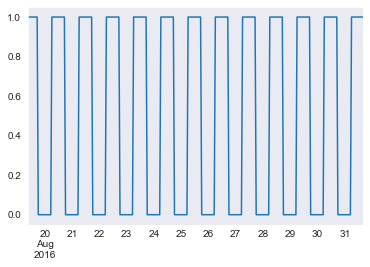

time: 2.94 s


In [131]:
mod = sm.tsa.statespace.SARIMAX(train, 
                                order=(1,1,1), 
                                seasonal_order=(1,0,1,12),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
# print(results.summary())

arima_pred = results.get_prediction(test.time.min(), test.time.max())
# arima_pred.predicted_mean.plot()

test_preds = arima_pred.predicted_mean.map(lambda x: 1 if x > 0.2 else 0)
test_preds.plot();

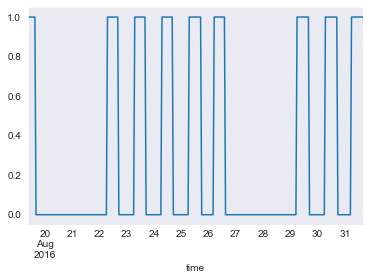

time: 404 ms


In [126]:
test.set_index('time').device_activated.plot();

In [89]:
print(metrics.classification_report(test.device_activated, test_preds.reset_index()[0]))

metrics.f1_score(test.device_activated, test_preds.reset_index()[0])

#### We can do better

In [14]:
from fbprophet import Prophet


time: 1.55 s


In [15]:
m = Prophet()
m.fit(train.reset_index().rename(columns={'index':'ds', 'device_activated':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/eamag/anaconda3/envs/pairf/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



time: 175 ms


In [16]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
1539,2017-08-15 08:00:00,1.575035,-2.182789,5.401954
1540,2017-08-16 08:00:00,1.646387,-2.466673,5.753939
1541,2017-08-17 08:00:00,2.674459,-1.556838,6.784971
1542,2017-08-18 08:00:00,2.133458,-2.072726,5.944979
1543,2017-08-19 08:00:00,-0.527709,-4.793039,3.330439


time: 7.11 s


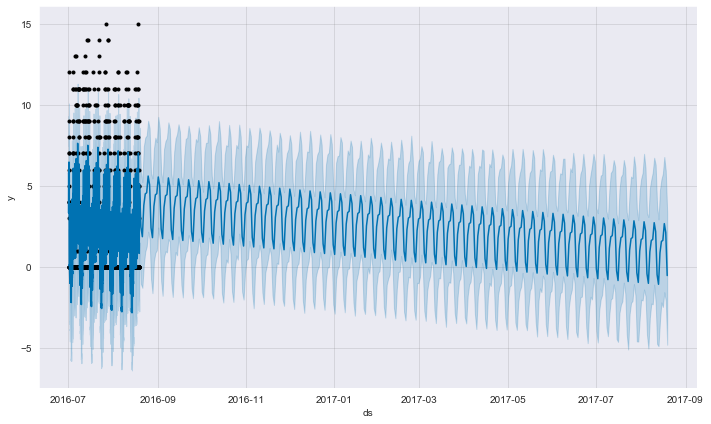

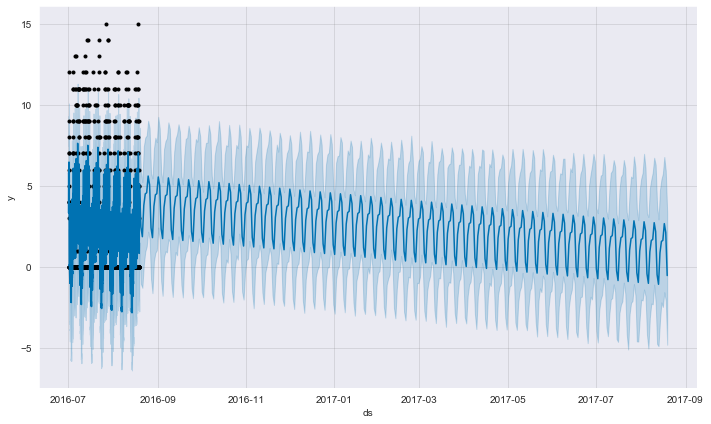

time: 813 ms


In [18]:
m.plot(forecast)

## Let's try the classics

In [12]:
train2 = train.copy()

time: 1.37 ms


In [13]:
train = train2.copy()

time: 2.03 ms


In [14]:
train = train.reset_index()

time: 3.15 ms


In [15]:
def add_datepart(df, fldname, drop=True, time=False):
        """add_datepart converts a column of df from a datetime64 to many columns containing
        the information from the date. This applies changes inplace.

        Parameters:
        -----------
        df: A pandas data frame. df gain several new columns.
        fldname: A string that is the name of the date column you wish to expand.
            If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
        drop: If true then the original date column will be removed.
        time: If true time features: Hour, Minute, Second will be added.

        """
        fld = df[fldname]
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64

        if not np.issubdtype(fld_dtype, np.datetime64):
            df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
        targ_pre = re.sub("[Dd]ate$", "", fldname)
        attr = [
            "Is_month_end",
            "Is_month_start",
            "Is_quarter_end",
            "Is_quarter_start",
            "Is_year_end",
            "Is_year_start",
            "dayofweek"
        ]
        if time:
            attr += ["Hour", "Minute", "Second"]
        for n in attr:
            df[targ_pre + n] = getattr(fld.dt, n.lower())
        if drop:
            df.drop(fldname, axis=1, inplace=True)

time: 2.18 ms


In [16]:
train = train.rename(columns={'index':'time'})

time: 2.6 ms


In [17]:
import re
add_datepart(train, 'time', drop=True, time=True)
add_datepart(test, 'time', drop=True, time=True)

/Users/eamag/anaconda3/envs/pairf/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


time: 550 ms


/Users/eamag/anaconda3/envs/pairf/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [21]:
y_train = train['device_activated'].copy()
train = train.drop(columns=['device_activated'])
y_test = test['device_activated'].copy()
test = test.drop(columns=['device_activated'])

categorical_features_indices = np.where(train.dtypes != np.float)[0]

train_pool = ctb.Pool(train, y_train, categorical_features_indices)
validation_pool = ctb.Pool(test, y_test, categorical_features_indices)

In [24]:

params = {
    'loss_function': 'Logloss',
    'iterations': 500,
    'early_stopping_rounds':50,
#     'custom_metric': ['MAE', 'Poisson', 'RMSE'],
    'custom_metric': ['AUC', 'Accuracy'],
    'cat_features': categorical_features_indices
#     'metric_period': 10
}

model = ctb.CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validation_pool, verbose=False, plot=True)


metrics.roc_auc_score(y_test.tolist(), model.predict_proba(test)[:, 1])

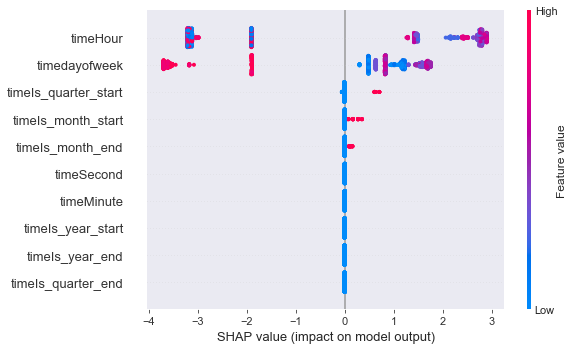

time: 1.9 s


In [25]:
import shap
shap.initjs()

shap_values = model.get_feature_importance(train_pool, fstr_type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, train)

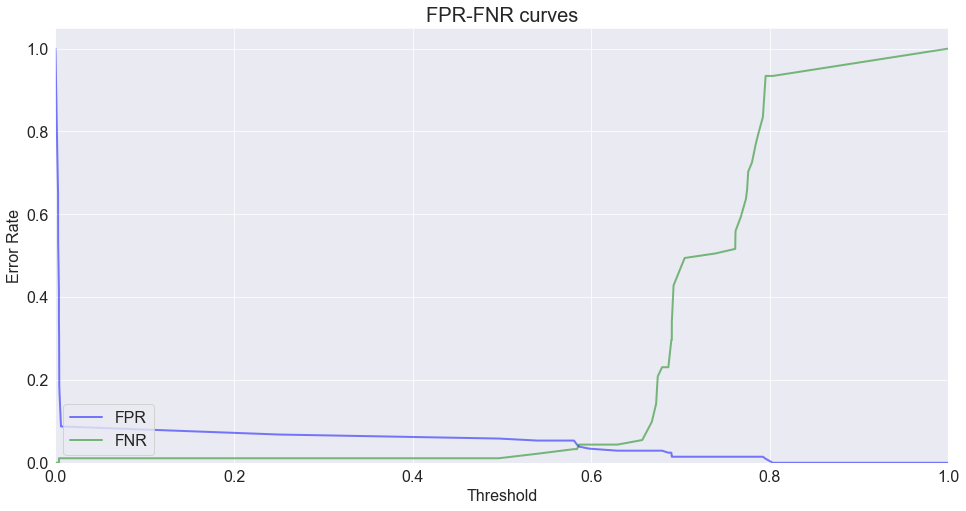

time: 463 ms


In [26]:
import matplotlib.pyplot as plt
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

curve = get_roc_curve(model, validation_pool)
(fpr, tpr, thresholds) = curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

plt.figure(figsize=(16, 8))
style = {'alpha':0.5, 'lw':2}

plt.plot(thresholds, fpr, color='blue', label='FPR', **style)
plt.plot(thresholds, fnr, color='green', label='FNR', **style)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16);

In [34]:
from catboost.utils import select_threshold

print(select_threshold(model, validation_pool, FNR=0.05))

0.6294811171901499
time: 7.14 ms


In [35]:
y_pred = pd.Series(model.predict_proba(test)[:, 1]).map(lambda x: 1 if x > 0.62 else 0)

time: 41.2 ms


In [36]:
print(metrics.classification_report(y_test, y_pred))

metrics.f1_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       205
           1       0.94      0.96      0.95        91

    accuracy                           0.97       296
   macro avg       0.96      0.96      0.96       296
weighted avg       0.97      0.97      0.97       296



0.9456521739130435

time: 15.9 ms


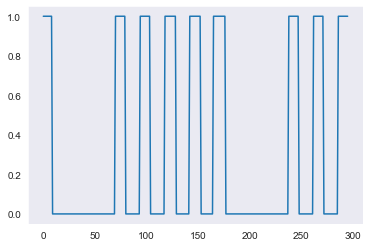

time: 393 ms


In [37]:
y_pred.plot();

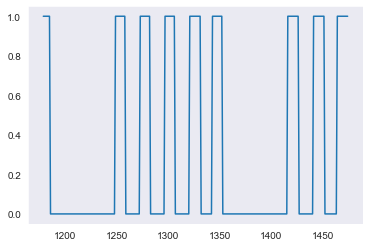

time: 398 ms


In [38]:
y_test.plot();

## Looks good enough

In [51]:
df = pd.read_csv('data/device_activations.csv', parse_dates=['time'])

time: 43.9 ms


In [58]:
for device in df.device.unique():
    df2 = df[df.device == device]
    df2  = df2.set_index('time').groupby(pd.Grouper(freq='H'))['device_activated'].sum().reset_index()
    df2.device_activated = df2.device_activated.map(lambda x: 1 if x > 0 else 0)
    split_point = -len(df2)//10*2
    train = df2[:split_point]
    val = df2[split_point:]
    add_datepart(train, 'time', drop=True, time=True)
    add_datepart(val, 'time', drop=True, time=True)
    y_train = train['device_activated'].copy()
    train = train.drop(columns=['device_activated'])
    y_val = val['device_activated'].copy()
    val = val.drop(columns=['device_activated'])

    categorical_features_indices = np.where(train.dtypes != np.float)[0]

    train_pool = ctb.Pool(train, y_train, categorical_features_indices)
    validation_pool = ctb.Pool(val, y_val, categorical_features_indices)
    
    params = {
        'loss_function': 'Logloss',
        'iterations': 500,
        'early_stopping_rounds':50,
        'custom_metric': ['AUC', 'Accuracy'],
        'cat_features': categorical_features_indices
    }

    model = ctb.CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=validation_pool, verbose=False)

    print(metrics.roc_auc_score(y_val.tolist(), model.predict_proba(val)[:, 1]))

    current_time = '2016-08-31 23:59:59'
    next_24_hours = pd.date_range(current_time, periods=24, freq='H').ceil('H')
    next_24_hours

    test = pd.DataFrame(next_24_hours, columns=['time'])

    add_datepart(test, 'time', drop=True, time=True)




    pred = model.predict_proba(test)[:,1]


    test = pd.DataFrame(next_24_hours, columns=['time'])
    test['device'] = device
    test['activation_predicted'] = pred



    from catboost.utils import select_threshold
    # We don't want to turn off the heating when people are in the office, so we set False Negative Rate to 5%
    threshold = select_threshold(model, validation_pool, FNR=0.05)
    test['activation_predicted'] = test['activation_predicted'].map(lambda x: 1 if x>threshold else 0)

In [83]:
out_df = pd.DataFrame(columns=['time', 'activation_predicted', 'device'])
out_df

,time,activation_predicted,device


time: 32.9 ms


In [99]:
from room_occupancy_predictor.room_occupancy_predictor import RoomOccupancyPredictor
in_file_path = 'data/device_activations.csv'
timestamp =  '2016-08-31 23:59:59'
rop = RoomOccupancyPredictor(in_file_path)


Model roc_auc: 0.9926807183459933
Model roc_auc: 0.9785312248726883
Model roc_auc: 0.9088122605363984
Model roc_auc: 0.9343266691814409
Model roc_auc: 0.9257744277966725
Model roc_auc: 0.8171119592875318
Model roc_auc: 0.9777531411677753


,time,activation_predicted,device
0,2016-09-01 00:00:00,0,device_1
1,2016-09-01 00:00:00,0,device_2
2,2016-09-01 00:00:00,0,device_3
3,2016-09-01 00:00:00,0,device_4
4,2016-09-01 00:00:00,0,device_5
5,2016-09-01 00:00:00,0,device_6
6,2016-09-01 00:00:00,1,device_7
7,2016-09-01 01:00:00,0,device_1
8,2016-09-01 01:00:00,0,device_2
9,2016-09-01 01:00:00,0,device_3


time: 1min 20s


In [112]:
!curl http://localhost:5000/predict?TOKEN=token

curl: (7) Failed to connect to localhost port 5000: Connection refused
time: 161 ms


In [102]:
rop.create_output_df(timestamp).to_dict('records')

[{'time': Timestamp('2016-09-01 00:00:00'),
  'activation_predicted': 0,
  'device': 'device_1'},
 {'time': Timestamp('2016-09-01 00:00:00'),
  'activation_predicted': 0,
  'device': 'device_2'},
 {'time': Timestamp('2016-09-01 00:00:00'),
  'activation_predicted': 0,
  'device': 'device_3'},
 {'time': Timestamp('2016-09-01 00:00:00'),
  'activation_predicted': 0,
  'device': 'device_4'},
 {'time': Timestamp('2016-09-01 00:00:00'),
  'activation_predicted': 0,
  'device': 'device_5'},
 {'time': Timestamp('2016-09-01 00:00:00'),
  'activation_predicted': 0,
  'device': 'device_6'},
 {'time': Timestamp('2016-09-01 00:00:00'),
  'activation_predicted': 1,
  'device': 'device_7'},
 {'time': Timestamp('2016-09-01 01:00:00'),
  'activation_predicted': 0,
  'device': 'device_1'},
 {'time': Timestamp('2016-09-01 01:00:00'),
  'activation_predicted': 0,
  'device': 'device_2'},
 {'time': Timestamp('2016-09-01 01:00:00'),
  'activation_predicted': 0,
  'device': 'device_3'},
 {'time': Timestamp('2016-09-01 01:00:00'),
  'activation_predicted': 0,
  'device': 'device_4'},
 {'time': Timestamp('2016-09-01 01:00:00'),
  'activation_predicted': 0,
  'device': 'device_5'},
 {'time': Timestamp('2016-09-01 01:00:00'),
  'activation_predicted': 0,
  'device': 'device_6'},
 {'time': Timestamp('2016-09-01 01:00:00'),
  'activation_predicted': 1,
  'device': 'device_7'},
 {'time': Timestamp('2016-09-01 02:00:00'),
  'activation_predicted': 0,
  'device': 'device_1'},
 {'time': Timestamp('2016-09-01 02:00:00'),
  'activation_predicted': 0,
  'device': 'device_2'},
 {'time': Timestamp('2016-09-01 02:00:00'),
  'activation_predicted': 0,
  'device': 'device_3'},
 {'time': Timestamp('2016-09-01 02:00:00'),
  'activation_predicted': 0,
  'device': 'device_4'},
 {'time': Timestamp('2016-09-01 02:00:00'),
  'activation_predicted': 0,
  'device': 'device_5'},
 {'time': Timestamp('2016-09-01 02:00:00'),
  'activation_predicted': 0,
  'device': 'device_6'},
 {'time': Timestamp('2016-09-01 02:00:00'),
  'activation_predicted': 1,
  'device': 'device_7'},
 {'time': Timestamp('2016-09-01 03:00:00'),
  'activation_predicted': 0,
  'device': 'device_1'},
 {'time': Timestamp('2016-09-01 03:00:00'),
  'activation_predicted': 0,
  'device': 'device_2'},
 {'time': Timestamp('2016-09-01 03:00:00'),
  'activation_predicted': 0,
  'device': 'device_3'},
 {'time': Timestamp('2016-09-01 03:00:00'),
  'activation_predicted': 0,
  'device': 'device_4'},
 {'time': Timestamp('2016-09-01 03:00:00'),
  'activation_predicted': 0,
  'device': 'device_5'},
 {'time': Timestamp('2016-09-01 03:00:00'),
  'activation_predicted': 0,
  'device': 'device_6'},
 {'time': Timestamp('2016-09-01 03:00:00'),
  'activation_predicted': 1,
  'device': 'device_7'},
 {'time': Timestamp('2016-09-01 04:00:00'),
  'activation_predicted': 0,
  'device': 'device_1'},
 {'time': Timestamp('2016-09-01 04:00:00'),
  'activation_predicted': 0,
  'device': 'device_2'},
 {'time': Timestamp('2016-09-01 04:00:00'),
  'activation_predicted': 0,
  'device': 'device_3'},
 {'time': Timestamp('2016-09-01 04:00:00'),
  'activation_predicted': 0,
  'device': 'device_4'},
 {'time': Timestamp('2016-09-01 04:00:00'),
  'activation_predicted': 0,
  'device': 'device_5'},
 {'time': Timestamp('2016-09-01 04:00:00'),
  'activation_predicted': 0,
  'device': 'device_6'},
 {'time': Timestamp('2016-09-01 04:00:00'),
  'activation_predicted': 1,
  'device': 'device_7'},
 {'time': Timestamp('2016-09-01 05:00:00'),
  'activation_predicted': 0,
  'device': 'device_1'},
 {'time': Timestamp('2016-09-01 05:00:00'),
  'activation_predicted': 0,
  'device': 'device_2'},
 {'time': Timestamp('2016-09-01 05:00:00'),
  'activation_predicted': 0,
  'device': 'device_3'},
 {'time': Timestamp('2016-09-01 05:00:00'),
  'activation_predicted': 0,
  'device': 'device_4'},
 {'time': Timestamp('2016-09-01 05:00:00'),
  'activation_predicted': 0,
  'device': 'device_5'},
 {'time': Timestamp('2016-09-01 05:00:00'),
  'activation_predicted': 0,
  'devi

time: 299 ms


{'model_1': (1, 2)}

time: 6.31 ms


In [98]:
for key, (val1,val2) in {'model_1': (1,2)}.items():
    print(key, val1, val2)

model_1 1 2
time: 2.24 ms
